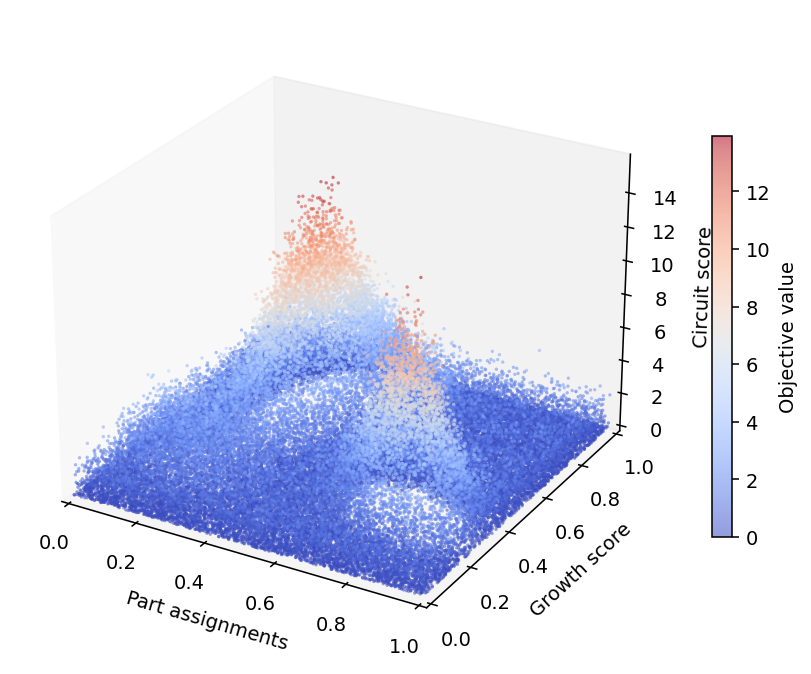

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------- Gaussian-mixture objective -------------------------
def gmm_mu(x, y, mus, covs, amps):
    """
    x, y: 1D arrays of same length (flat coordinates in [0,1])
    mus:  list of 2D means, shape (K,2)
    covs: list of 2x2 covariances (SPD), shape (K,2,2)
    amps: list/array of positive amplitudes, shape (K,)
    Returns mu(x,y) = sum_k amps[k] * N([x,y] | mu_k, cov_k)  (unnormalized)
    """
    z = np.zeros_like(x, dtype=float)
    for (mx, my), S, a in zip(mus, covs, amps):
        # Mahalanobis distance for each point
        dx = x - mx
        dy = y - my
        # inverse and det (2x2 fast path)
        det = S[0,0]*S[1,1] - S[0,1]*S[1,0]
        inv = (1.0/det) * np.array([[ S[1,1], -S[0,1]],
                                    [-S[1,0],  S[0,0]]])
        q = inv[0,0]*dx*dx + 2*inv[0,1]*dx*dy + inv[1,1]*dy*dy
        z += a * np.exp(-0.5*q)
    return z

# ------------------------- mixture definition (edit me) -----------------------
# 4 components: (mean), covariance, amplitude (controls peak height)
mus  = np.array([
    [0.30, 0.70],   # tall, narrow-ish, rotated
    [0.78, 0.32],   # tall
    [0.58, 0.75],   # medium side bump
    [0.18, 0.28],   # low hill filling the basin
])
# Covariances (elliptical, oriented). Tune these to reshape lobes.
def cov(ax, ay, rho):
    return np.array([[ax*ax, rho*ax*ay],
                     [rho*ax*ay, ay*ay]])
covs = [
    cov(0.08, 0.15,  0.35),
    cov(0.10, 0.07, -0.25),
    cov(0.06, 0.06,  0.10),
    cov(0.12, 0.10,  0.00),
]
amps = np.array([10.0, 9.0, 3.0, 1.8])  # relative peak heights

# ----------------------------- sample point cloud -----------------------------
N   = 55_000
rng = np.random.default_rng(42)

# ground plane sampling (uniform; not a grid)
x = rng.uniform(0.00, 1.00, N)
y = rng.uniform(0.00, 1.00, N)

# expected objective from the Gaussian mixture
mu = gmm_mu(x, y, mus, covs, amps)

# optional gentle global tilt so the floor stays bluish toward one corner
mu = mu 

# heteroscedastic vertical jitter (speckled tops), then clamp to 0–max
sigma = 0.18*np.sqrt(np.clip(mu, 0, None)) + 1.0
z = np.clip(mu + rng.normal(0, sigma), 0, None)

# optional: thicken the blue base irregularly so it reads like a cloud
#carpet_prob = np.clip(0.32 - 0.22*mu/amps.max(), 0.05, 0.33)
#carpet = rng.random(N) < carpet_prob
#z[carpet] *= rng.uniform(0.07, 0.25, carpet.sum())

# ------------------------------- plot ----------------------------------------
fig = plt.figure(figsize=(9.5, 6), dpi=140)
ax = fig.add_subplot(111, projection='3d')

pts = ax.scatter(
    x, y, z,
    c=z, cmap='coolwarm', s=3.0, alpha=0.55, linewidths=0
)

ax.view_init(elev=26, azim=-60)
ax.set_xlim(0, 1);  ax.set_ylim(0, 1);  ax.set_zlim(0, z.max()+2)

ax.set_xlabel("Part assignments")
ax.set_ylabel("Growth score")
ax.set_zlabel("Circuit score")

# cleaner look (hide grid planes)
for axis in ("x", "y", "z"):
    ax.__getattribute__(f"{axis}axis")._axinfo["grid"]["linewidth"] = 0

fig.colorbar(pts, ax=ax, shrink=0.62, pad=0.05, label='Objective value')




In [ ]:
plt.savefig("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/objective_surface.svg")     # vector for Illustrator touch-ups
plt.show()

In [4]:
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Flowable
from reportlab.graphics.shapes import Drawing, Rect, String, Line
from reportlab.graphics import renderPDF

# Smaller diagram to fit on page
class GATDiagram(Flowable):
    def __init__(self, width=400, height=500):
        Flowable.__init__(self)
        self.width = width
        self.height = height

    def draw(self):
        d = Drawing(self.width, self.height)

        layer_height = 60
        res_height = 18
        box_width = 300
        x0 = 40
        y0 = self.height - 80

        # Input
        d.add(Rect(x0+90, y0+layer_height+res_height+20, 100, 25,
                   strokeColor=colors.black, fillColor=None))
        d.add(String(x0+100, y0+layer_height+res_height+28,
                     "X (features)", fontSize=8))

        # Three GAT layers
        for i in range(3):
            y_layer = y0 - i*(layer_height+res_height+50)
            # Layer box
            d.add(Rect(x0, y_layer, box_width, layer_height,
                       strokeColor=colors.black, fillColor=None, radius=4))
            d.add(String(x0+5, y_layer+layer_height-12,
                         f"GAT Layer {i+1}", fontSize=9))

            # Compartments
            d.add(Rect(x0+15, y_layer+18, 80, 25, strokeColor=colors.black))
            d.add(String(x0+20, y_layer+25, "Multi-head\nAttention", fontSize=6))
            d.add(Rect(x0+110, y_layer+18, 60, 25, strokeColor=colors.black))
            d.add(String(x0+120, y_layer+25, "Aggregate", fontSize=6))
            d.add(Rect(x0+190, y_layer+18, 80, 25, strokeColor=colors.black))
            d.add(String(x0+195, y_layer+25, "Projection", fontSize=6))

            # Residual + LN
            d.add(Rect(x0+90, y_layer-20, 100, res_height, strokeColor=colors.black))
            d.add(String(x0+95, y_layer-16, "Residual + LN", fontSize=6))

            # Output H^i
            d.add(Rect(x0+120, y_layer-45, 40, 18, strokeColor=colors.black))
            d.add(String(x0+125, y_layer-41, f"H^{i+1}", fontSize=6))

            # Vertical arrows
            if i == 0:
                d.add(Line(x0+140, y_layer+layer_height+15, x0+140,
                           y_layer+layer_height, strokeColor=colors.black))
            d.add(Line(x0+140, y_layer-2, x0+140, y_layer-20, strokeColor=colors.black))
            d.add(Line(x0+140, y_layer-35, x0+140, y_layer-45, strokeColor=colors.black))

        # Attention inset
        inset_x = 40
        inset_y = 20
        d.add(Rect(inset_x, inset_y, 300, 80, strokeColor=colors.black, radius=4))
        d.add(String(inset_x+5, inset_y+65, "Attention Head (Zoom-in)", fontSize=8))
        d.add(String(inset_x+5, inset_y+50, "e_ij = a^T σ(W[h_i || h_j])", fontSize=7))
        d.add(String(inset_x+5, inset_y+38, "α_ij = softmax_j(e_ij)", fontSize=7))
        d.add(String(inset_x+5, inset_y+26, "m_ij = α_ij W_v h_j", fontSize=7))
        d.add(String(inset_x+5, inset_y+14, "h'_i = φ(Σ_j m_ij)", fontSize=7))

        renderPDF.draw(d, self.canv, 0, 0)

# Build PDF
output_path = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/gat_3layers_diagram.pdf"
doc = SimpleDocTemplate(output_path, pagesize=letter)
elements = [GATDiagram()]
doc.build(elements)

output_path


'/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/gat_3layers_diagram.pdf'